## What is clustering?
Clustering is a type of unsupervised learning. Us humans would think of it as 'categorization' perhaps. For example if I gave you a bag of red, blue and white balls and asked you to sort them (without telling you how) you would probably naturally gravitate towards sorting them by colour as this would be the most obvious choice.<p>

<img src='unsorted.jpg' width='30%' />   <img src='sorted.jpg' width='30%' /><p>

### The problem with clustering...
The big trick with clustering is that (unlike with human categorization) you have to specify <i>up-front</i> how many clusters to use in your grouping. If I give you this task and say 'sort these balls into 3 logical groups', you're likely to do a fabulous job. But if I give you this task and say 'sort these balls into 5 logical groups' - you're going to struggle! There are likely to be at least 2 or 3 groups that end up being pretty ambiguously sorted. And, unlike in this example where it's obvious how many groups to choose, our data is usually pretty complex: there could be 10 groups or there could be 100 groups - we won't have a clue!<p>
    
### How do we get around that problem?
So what we typically do, is we say: I don't know how many clusters (groups) this data should be split in SO, sort it into 2, 3, 5, and 8 groups - and then at the end I'll pick the one I think has the best results.

## An example - clustering words with word2vec

In this example we're going to look at clustering similar words, which are represented using [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/). You can download the GloVe embeddings (glove.6B.50d.txt) e.g. from [here](https://www.kaggle.com/watts2/glove6b50dtxt), or download the full set, if you prefer, from [here](https://nlp.stanford.edu/projects/glove/).<p>
    
Each word is represented by a vector of length 50. We'll use PCA to reduce the vector size, and then use KMeans to see if we can find an optimum number of clusters for our words. In this example I'm using clearly-defined clusters of words so we can see how the evaluation part works:

- <b>Car stuff</b>: 'car', 'carburettor', 'engine', 'wheel', 'steering', 'gear'
- <b>Computer stuff</b>: 'computer', 'email', 'screen', 'keyboard', 'programming'
- <b>Animal stuff</b>: 'dog', 'cat', 'cow', 'sheep', 'chicken', 'pig'
- <b>Utensils stuff</b>: 'knife', 'fork', 'spoon', 'plate', 'bowl', 'cup'
- <b>Building stuff</b>: 'house', 'building', 'dwelling', 'apartment', 'accommodation'

### Preparatory steps

In [1]:
# Import our PCA and KMeans tools
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import additional helper libraries used in the notebook for processing and visualization
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Define a function to load the Glove model 
# (from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python)
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [3]:
# Load the model and have a look at a 2 words and how they are represented
# (you'll need to change the folder location to wherever YOU stored the file you downloaded)
glove_model = loadGloveModel('../UniversalDataFiles/glove.6B.50d.txt')
print(glove_model['dog'])
print(glove_model['cat'])
# We've know that these words should end up being 'related' - but that is totally not yet apparent!

Loading Glove Model
Done. 400000  words loaded!
[ 0.11008   -0.38781   -0.57615   -0.27714    0.70521    0.53994
 -1.0786    -0.40146    1.1504    -0.5678     0.0038977  0.52878
  0.64561    0.47262    0.48549   -0.18407    0.1801     0.91397
 -1.1979    -0.5778    -0.37985    0.33606    0.772      0.75555
  0.45506   -1.7671    -1.0503     0.42566    0.41893   -0.68327
  1.5673     0.27685   -0.61708    0.64638   -0.076996   0.37118
  0.1308    -0.45137    0.25398   -0.74392   -0.086199   0.24068
 -0.64819    0.83549    1.2502    -0.51379    0.04224   -0.88118
  0.7158     0.38519  ]
[ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.0974

In [4]:
# Let's get our words of interest that we'd like to explore
words_of_interest = ['car', 'carburettor', 'engine', 'wheel', 'steering', 'gear',
                     'computer', 'email', 'screen', 'keyboard', 'programming',
                     'dog', 'cat', 'cow', 'sheep', 'chicken', 'pig', 
                     'knife', 'fork', 'spoon', 'plate', 'bowl', 'cup',
                     'house', 'building', 'dwelling', 'apartment', 'accommodation']

# And assign labels, based on the clusters we can understand as humans (see above)
word_labels = [0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4]

# And finally get their corresponding vectors from our GloVe model
word_vectors = np.zeros(shape = (len(words_of_interest), 50))
for i in range(len(words_of_interest)):
        word_vectors[i] = glove_model[words_of_interest[i]]

In [5]:
# Instead of working with 50-feature vectors I'd like to reduce that - for this toy example that's 
# not strictly necessary, but with bigger datasets and longer vectors it will usually be beneficial
pca = decomposition.PCA(n_components=20)
pca.fit(word_vectors)
X = pca.transform(word_vectors)
# Notice how, instead of 50 values for each row in our dataset we now have 20 values
print('Sample data: \n {}'.format(X[0:2]))

Sample data: 
 [[-1.91045907e+00  1.10576728e+00  9.48095139e-01 -2.80791680e+00
   1.06608406e+00  2.89879317e-01 -1.45847540e-02  3.33787045e-01
   8.32785803e-01  2.61371905e-01  4.66594992e-01 -4.56137065e-01
   1.19593472e+00  4.28161136e-01  1.33643113e-01 -3.15812907e-01
   5.45334033e-02 -1.90354267e-03  4.01203145e-01  2.31313936e-01]
 [-1.18080476e+00 -1.75755541e+00 -3.18869765e+00 -1.03440363e+00
  -1.65051885e+00 -2.14235231e+00 -1.60473982e+00  2.12774683e+00
   5.62326549e-01 -3.07814038e-01  8.85947943e-01 -8.74207980e-04
  -4.61617866e-01  4.38939298e-02 -3.34205232e-01 -1.91850412e-03
  -1.79549554e-01  1.77190078e-01 -1.36622415e-01  3.10037764e-01]]


In [6]:
# Let's say we want 80% of the variance explained by the features we choose to include. 
# It looks like including the first 10 features will get us to that target (item 10 at 82.89%):
np.cumsum(pca.explained_variance_ratio_[0:20])

array([0.1976727 , 0.32836805, 0.44007133, 0.53384522, 0.61940629,
       0.68738938, 0.72963746, 0.76887258, 0.80067454, 0.8288686 ,
       0.85536648, 0.87814626, 0.8973912 , 0.91522914, 0.92957705,
       0.9413561 , 0.95223509, 0.96280631, 0.9705716 , 0.97722853])

In [7]:
# So let's re-run to get the vectors we'll use for KMeans
pca = decomposition.PCA(n_components=10)
pca.fit(word_vectors)
X = pca.transform(word_vectors)
print(X[0:5])

[[-1.91045907  1.10576728  0.94809514 -2.8079168   1.06608406  0.28987932
  -0.01458475  0.33378704  0.8327858   0.2613719 ]
 [-1.18080476 -1.75755541 -3.18869765 -1.03440363 -1.65051885 -2.14235231
  -1.60473982  2.12774683  0.56232655 -0.30781404]
 [-2.61975367 -1.11452556 -0.72489868 -2.48511733  0.3270813  -0.89888128
   1.16508104  0.83441162 -1.17096479  0.18844364]
 [-1.5963012  -0.97687178 -0.1653088  -2.34838492 -0.30164832  0.60588144
   0.14860095 -1.00273761 -0.1344437  -0.37420308]
 [-1.77199066 -1.30946018 -0.32352033 -0.98453077 -0.77226464  0.49568545
   0.67272789 -1.04482705  0.23904818  0.70664755]]


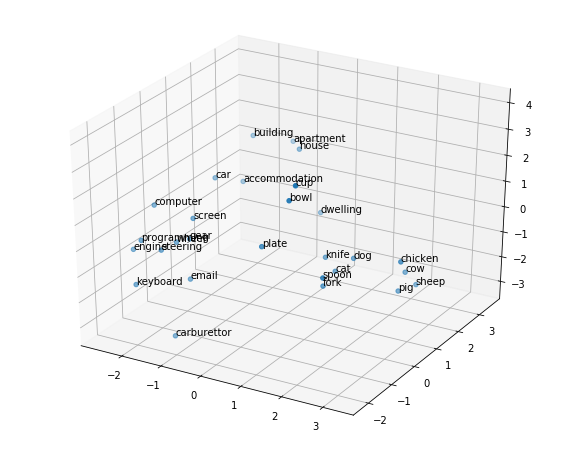

In [8]:
# And now we can put it into a dataframe for convenience and plot the results, 
# with our first 3 (nameless) components represented by each of our 3 axes
# - note we're only plotting with the first 3 components here, as we can't plot in 10D!
result=pd.DataFrame(X)
result['label'] = words_of_interest
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result[0], result[1], result[2])
for word, x, y, z in zip(words_of_interest, result[0], result[1], result[2]):   
    ax.text(x, y, z, word)
# One can visually see that these words DO form clusters, for example 
# building, house and apartment at the top; chicken, cow, sheep, pig at the right

### Clustering and evaluation

The [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is commonly used to evaluate which is the optimum number of clusters to choose, however, the [silhouette method](https://en.wikipedia.org/wiki/Silhouette_(clustering)) can sometimes give a clearer indication - we'll compare the two against what we know is the ground truth (5 clusters is best) and see which one was closer.

In [9]:
# So here we are going to try clustering with different numbers of clusters

# Create a df to hold our results in
cluster_map = pd.DataFrame()
cluster_map['data_words'] = words_of_interest
cluster_map['data_index'] = word_labels

# Specify numbers of clusters to try
no_clusters = [2, 5, 8, 12]

# Store elbow and silhouette metrics for evaluation later
eval_elbow= []
eval_silhouette = []

for i in no_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=1000, 
        tol=1e-04, random_state=0).fit(X)
    
    cluster_map[i]= km.labels_

    eval_elbow.append(km.inertia_)
    eval_silhouette.append(silhouette_score(X,km.labels_))

#### Elbow method
Our elbow is rather rounded - it's pretty hard to actually see where the best cut-off point would be using this method in this situation:

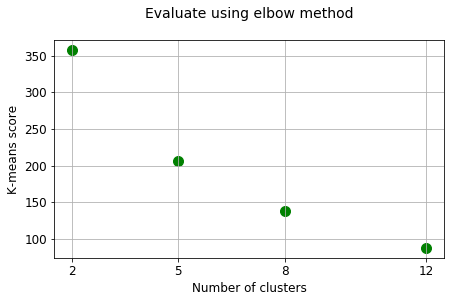

In [10]:
plt.figure(figsize=(7,4))
plt.title('Evaluate using elbow method\n',fontsize=14)
plt.scatter(x = [i for i in no_clusters], y = eval_elbow, s = 100, color='green')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=12)
plt.ylabel("K-means score",fontsize=12)
plt.xticks([i for i in no_clusters],fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Silhouette method
On the other hand the silhouette method provides us with a nice clear indication that 5 is best (which we also know to be the truth of the matter):

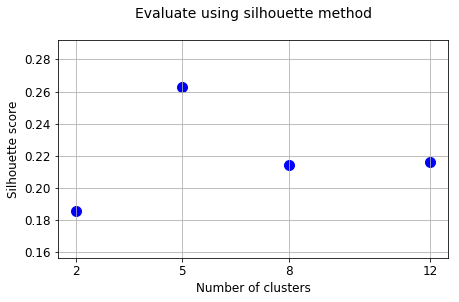

In [11]:
plt.figure(figsize=(7,4))
plt.title('Evaluate using silhouette method\n',fontsize=14)
plt.scatter(x = [i for i in no_clusters], y = eval_silhouette, s = 100, color='blue')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=12)
plt.ylabel("Silhouette score",fontsize=12)
plt.xticks([i for i in no_clusters],fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In unsupervised machine learning, however, metrics are not everything. It also comes down to just having a look at the data and seeing whether the results make sense from a human perspective or not. <p>
    
Below is our dataframe of results. The column <b>data_index</b> shows how WE grouped the words. The columns, <b>2</b>, <b>5</b>, <b>8</b>, and <b>12</b> show  KMeans grouped them at each iteration. By examining the data we see that for the iteration with 5 clusters only ONE item (<i>knife</i>) was placed in a different group to how we had it - a pretty good result!<p>

In [12]:
cluster_map

,data_words,data_index,2,5,8,12
0,car,0,0,3,6,5
1,carburettor,0,0,3,5,4
2,engine,0,0,3,0,5
3,wheel,0,0,3,0,5
4,steering,0,0,3,0,5
5,gear,0,0,3,6,5
6,computer,1,0,1,4,10
7,email,1,0,1,4,6
8,screen,1,0,1,4,9
9,keyboard,1,0,1,4,9
